In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from math import sqrt, ceil

import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import transforms
import torch.utils.data as data

from random import shuffle
from PIL import Image

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
SEG_LABELS_LIST = [
    {"id": -1, "name": "void",       "rgb_values": [0,   0,    0]},
    {"id": 0,  "name": "building",   "rgb_values": [128, 0,    0]},
    {"id": 1,  "name": "grass",      "rgb_values": [0,   128,  0]},
    {"id": 2,  "name": "tree",       "rgb_values": [128, 128,  0]},
    {"id": 3,  "name": "cow",        "rgb_values": [0,   0,    128]},
    {"id": 4,  "name": "horse",      "rgb_values": [128, 0,    128]},
    {"id": 5,  "name": "sheep",      "rgb_values": [0,   128,  128]},
    {"id": 6,  "name": "sky",        "rgb_values": [128, 128,  128]},
    {"id": 7,  "name": "mountain",   "rgb_values": [64,  0,    0]},
    {"id": 8,  "name": "airplane",   "rgb_values": [192, 0,    0]},
    {"id": 9,  "name": "water",      "rgb_values": [64,  128,  0]},
    {"id": 10, "name": "face",       "rgb_values": [192, 128,  0]},
    {"id": 11, "name": "car",        "rgb_values": [64,  0,    128]},
    {"id": 12, "name": "bicycle",    "rgb_values": [192, 0,    128]},
    {"id": 13, "name": "flower",     "rgb_values": [64,  128,  128]},
    {"id": 14, "name": "sign",       "rgb_values": [192, 128,  128]},
    {"id": 15, "name": "bird",       "rgb_values": [0,   64,   0]},
    {"id": 16, "name": "book",       "rgb_values": [128, 64,   0]},
    {"id": 17, "name": "chair",      "rgb_values": [0,   192,  0]},
    {"id": 18, "name": "road",       "rgb_values": [128, 64,   128]},
    {"id": 19, "name": "cat",        "rgb_values": [0,   192,  128]},
    {"id": 20, "name": "dog",        "rgb_values": [128, 192,  128]},
    {"id": 21, "name": "body",       "rgb_values": [64,  64,   0]},
    {"id": 22, "name": "boat",       "rgb_values": [192, 64,   0]}]

def label_img_to_rgb(label_img):
    label_img = np.squeeze(label_img) 
    labels = np.unique(label_img) # get unique labels
    label_infos = [l for l in SEG_LABELS_LIST if l['id'] in labels]
    
    label_img_rgb = np.array([label_img, label_img, label_img]).transpose(1,2,0)
    for l in label_infos:
        mask = label_img == l['id']
        label_img_rgb[mask] = l['rgb_values']    
    return label_img_rgb.astype(np.uint8)

In [4]:
class SegmentationData(data.Dataset):
    
    def __init__(self, image_paths_file):
        self.root_dir_name = os.path.dirname(image_paths_file)
        
        with open(image_paths_file) as f:
            self.image_names = f.read().splitlines()
            
    def __getitem__(self, key):
        if isinstance(key, slice):
            # get the start, stop and step from the slice
            return [self[i] for i in range(*key.indices(len(self)))]
        elif isinstance(key, int):
            # handle negative indices
            if key < 0:
                key += len(self)
            if key < 0 or key >= len(self):
                raise IndexError('The index (%d) is out of ragne.'%key)
            return self.get_item_from_index(key)
        else:
            raise TypeError('Invalid argument type.')
    
    def __len__(self):
        return len(self.image_names)
    
    def get_item_from_index(self, index):
        to_tensor = transforms.ToTensor()
        img_id = self.image_names[index].replace('.bmp','')
        img = Image.open(os.path.join(self.root_dir_name,'images',
                                      img_id+'.bmp')).convert('RGB')
        center_crop = transforms.CenterCrop(240)
        img = center_crop(img)
        img = to_tensor(img)
        
        target = Image.open(os.path.join(self.root_dir_name,'targets',
                                      img_id+'_GT.bmp')).convert('RGB')
        target = center_crop(target)
        target = np.array(target,dtype=np.int64)
        
        target_labels = target[...,0]
        
        for label in SEG_LABELS_LIST:
            mask = np.all(target==label['rgb_values'],axis=2)
            target_labels[mask] = label['id']
            
        target_labels = torch.from_numpy(target_labels.copy())
        
        return img, target_labels


In [5]:
train_data = SegmentationData(image_paths_file='datasets/segmentation_data/train.txt')
val_data = SegmentationData(image_paths_file='datasets/segmentation_data/val.txt')

Train size: 276
Validation size: 59
Img size: torch.Size([3, 240, 240])
Segmentation size: torch.Size([240, 240])


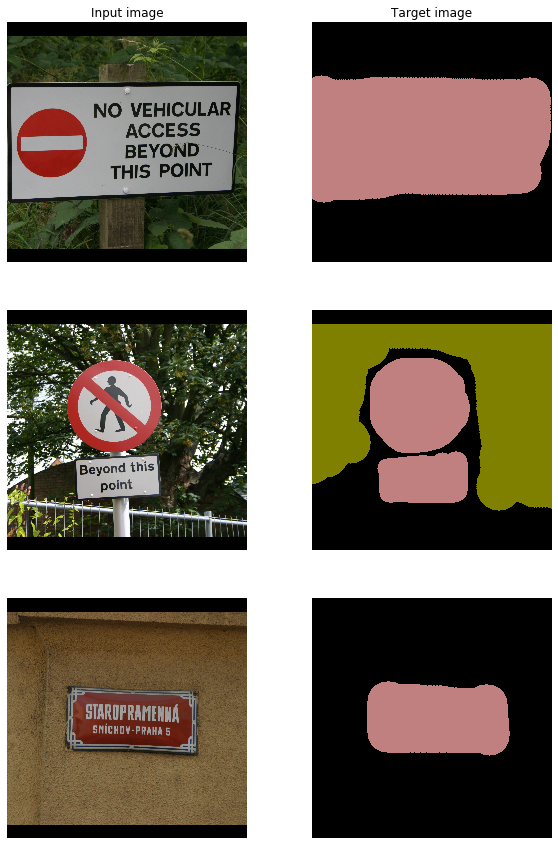

In [6]:
print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))
print("Img size:", train_data[0][0].size())
print("Segmentation size:", train_data[0][1].size())

num_example_imgs = 3
plt.figure(figsize=(10, 5 * num_example_imgs))
for i,(img,target) in enumerate(train_data[:num_example_imgs]):
    #img
    plt.subplot(num_example_imgs,2,i*2+1)
    plt.imshow(img.numpy().transpose(1,2,0)) # img.shape = (240,240,3)
    plt.axis('off')
    if i==0:
        plt.title('Input image')
        
    #target
    plt.subplot(num_example_imgs,2,i*2+2)
    plt.imshow(label_img_to_rgb(target.numpy()))
    plt.axis('off')
    if i==0:
        plt.title('Target image')
plt.show()

In [7]:
class SegmentationNN(nn.Module):
    
    def __init__(self, num_classes=23):
        super(SegmentationNN, self).__init__()
        
        self.features = models.alexnet(pretrained=True).features
        self.classifier = nn.Sequential(nn.Dropout(),
                                       nn.Conv2d(256,4096,kernel_size=1),
                                       nn.ReLU(inplace=True),
                                       nn.Dropout(),
                                       nn.Conv2d(4096,4096,kernel_size=1),
                                       nn.ReLU(inplace=True),
                                       nn.Conv2d(4096,num_classes,kernel_size=1))
        self.conv = nn.Conv2d(num_classes, num_classes, kernel_size=3, padding=1)
    
    def forward(self,x):
        '''
        Inputs:
        - x: PyTorch input Variable
        '''
        x = self.features(x)
        x = self.classifier(x)
        
        x = F.interpolate(input=x,scale_factor=40)
        x = self.conv(x)
        return x
    
    def is_cuda(self):
        '''
        Check if model parameters are allocated on the GPU'''
        return next(self.parameters()).is_cuda
    
    def save(self,path):
        '''
        Save model with its parameters to the given path. Conventionally the
        path should end with "*.model".
        
        Inputs:
        - path: path string'''
        print('Save model... %s'% path)
        torch.save(self, path)

In [8]:
class Solver(object):
    default_adam_args = {'lr':1e-4, 'betas':(0.9,0.999),'eps':1e-8,
                         'weight_decay':0.0}
    
    def __init__(self,optim=torch.optim.Adam,optim_args={},
                 loss_func=torch.nn.CrossEntropyLoss()):
        optim_args_merged = self.default_adam_args.copy()
        optim_args_merged.update(optim_args)
        self.optim_args = optim_args_merged
        self.optim = optim
        self.loss_func = loss_func
        
        self._reset_histories()
        
    def _reset_histories(self):
        '''
        Resets train and val histories for the accuracy and the loss
        '''
        self.train_loss_history = []
        self.train_acc_history = []
        self.val_loss_history = []
        self.val_acc_history = []
        
    def train(self, model, train_loader, val_loader, num_epochs = 10, log_nth = 0):
        '''
        Train a given model with the provided data
        
        Inputs:
        - model: model object initialized from a torch.nn.Module
        - train_loader: train data in torch.utils.data.DataLoader
        - val_loader: val data in torch.utils.data.DataLoader
        - num_epochs: total number of training epochs
        - log_nth: log training accuracy and loss every nth iteration
        '''
        optim = self.optim(model.parameters(),**self.optim_args)
        self._reset_histories()
        iter_per_epoch = len(train_loader)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model.to(device)
        
        print('Start Train.')
        
        for epoch in range(num_epochs):

            train_scores = []
            model.train()
            for i, (inputs, targets) in enumerate(train_loader, 1): # i begins with 1
                inputs, targets = inputs.to(device), targets.to(device)

                optim.zero_grad()
                outputs = model(inputs)
                loss = self.loss_func(outputs, targets)
                loss.backward()
                optim.step()

                self.train_loss_history.append(loss.item())
                if log_nth and i % log_nth == 0:
                    last_log_nth_losses = self.train_loss_history[-log_nth:]
                    train_loss = np.mean(last_log_nth_losses)
                    print('[Iteration %d/%d] TRAIN loss: %.3f' % \
                        (i + epoch * iter_per_epoch,
                         iter_per_epoch * num_epochs,
                         train_loss))

                _, preds = torch.max(outputs, 1)

                # Only allow images/pixels with label >= 0 e.g. for segmentation
                targets_mask = targets >= 0
                scores = np.mean((preds == targets)[targets_mask].data.cpu().numpy())
                train_scores.append(scores)
            
            train_acc = np.mean(train_scores)
            self.train_acc_history.append(train_acc)
            if log_nth:
                print('[Epoch %d/%d] TRAIN acc/loss: %.3f/%.3f' % (epoch + 1, num_epochs,train_acc,train_loss))
            
            val_losses = []
            val_scores = []
            model.eval()
            for inputs, targets in val_loader:
                if model.is_cuda:
                    inputs, targets = inputs.to(device), targets.to(device)
                    
                outputs = model(inputs)
                loss = self.loss_func(outputs, targets)                
                val_losses.append(loss.item()) 
                
                _, preds = torch.max(outputs,1)
                
                targets_mask = targets >= 0
                scores = np.mean((preds ==  targets)[targets_mask].data.cpu().numpy())
                val_scores.append(scores)
                
            val_acc, val_loss = np.mean(val_scores), np.mean(val_losses)
            self.val_acc_history.append(val_acc)
            self.val_loss_history.append(val_loss)
            if log_nth:
                print('[Epoch %d/%d] VAL acc/loss: %.3f/%.3f' % 
                          (epoch + 1,
                           num_epochs,
                           val_acc,
                          val_loss))
        print('Finish')

In [9]:
train_loader = torch.utils.data.DataLoader(train_data,batch_size=10,shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_data,batch_size=1,shuffle=False, num_workers=0)

model = SegmentationNN()
model.to(device)
solver = Solver(optim_args = {'lr':1e-4,'weight_decay':0.001},
               loss_func=torch.nn.CrossEntropyLoss(size_average=True,ignore_index=-1))
solver.train(model, train_loader, val_loader, log_nth=5,num_epochs=5)

D:\Anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Start Train.
[Iteration 5/140] TRAIN loss: 3.085
[Iteration 10/140] TRAIN loss: 2.827
[Iteration 15/140] TRAIN loss: 2.753
[Iteration 20/140] TRAIN loss: 2.550
[Iteration 25/140] TRAIN loss: 2.463
[Epoch 1/5] TRAIN acc/loss: 0.219/2.463
[Epoch 1/5] VAL acc/loss: 0.445/2.030
[Iteration 33/140] TRAIN loss: 2.066
[Iteration 38/140] TRAIN loss: 1.849
[Iteration 43/140] TRAIN loss: 1.909
[Iteration 48/140] TRAIN loss: 1.764
[Iteration 53/140] TRAIN loss: 1.730
[Epoch 2/5] TRAIN acc/loss: 0.481/1.730
[Epoch 2/5] VAL acc/loss: 0.617/1.554
[Iteration 61/140] TRAIN loss: 1.402
[Iteration 66/140] TRAIN loss: 1.483
[Iteration 71/140] TRAIN loss: 1.413
[Iteration 76/140] TRAIN loss: 1.311
[Iteration 81/140] TRAIN loss: 1.414
[Epoch 3/5] TRAIN acc/loss: 0.616/1.414
[Epoch 3/5] VAL acc/loss: 0.645/1.280
[Iteration 89/140] TRAIN loss: 1.246
[Iteration 94/140] TRAIN loss: 0.984
[Iteration 99/140] TRAIN loss: 1.076
[Iteration 104/140] TRAIN loss: 0.964
[Iteration 109/140] TRAIN loss: 1.207
[Epoch 4/5] 

In [10]:
test_data = SegmentationData(image_paths_file='datasets/segmentation_data_test/test.txt')
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=1,
                                          shuffle=False,
                                          num_workers=0)

test_scores = []
model.eval()
for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    
    outputs = model.forward(inputs)
    _, preds = torch.max(outputs, 1)
    targets_mask = targets >= 0
    test_scores.append(np.mean((preds == targets)[targets_mask].data.cpu().numpy()))
    
model.train()
np.mean(test_scores)

0.736658407876171

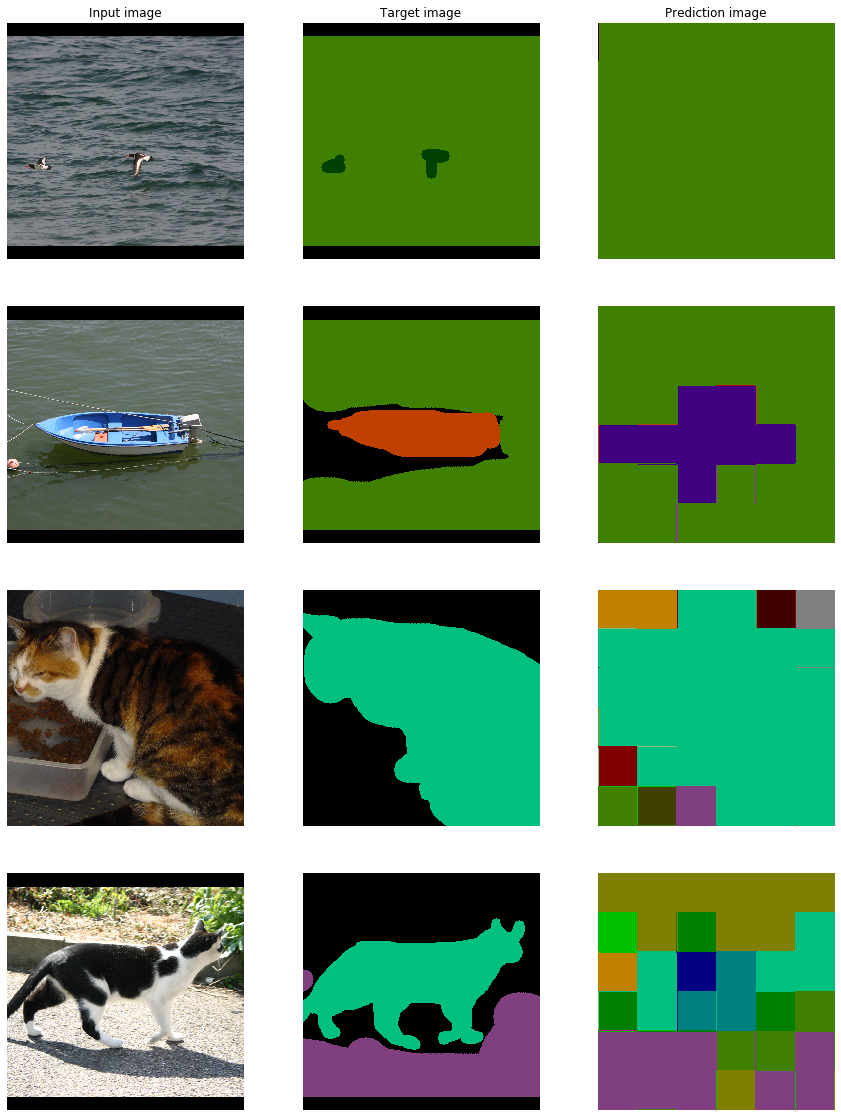

In [11]:
num_example_imgs = 4
plt.figure(figsize=(15, 5 * num_example_imgs))
for i, (img, target) in enumerate(test_data[:num_example_imgs]):
    inputs = img.unsqueeze(0)
    inputs = inputs.to(device)
    
    outputs = model.forward(inputs)
    _, preds = torch.max(outputs, 1)
    pred = preds[0].data.cpu()
    
    img, target, pred = img.numpy(), target.numpy(), pred.numpy()
    
    # img
    plt.subplot(num_example_imgs, 3, i * 3 + 1)
    plt.axis('off')
    plt.imshow(img.transpose(1,2,0))
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 3, i * 3 + 2)
    plt.axis('off')
    plt.imshow(label_img_to_rgb(target))
    if i == 0:
        plt.title("Target image")

    # pred
    plt.subplot(num_example_imgs, 3, i * 3 + 3)
    plt.axis('off')
    plt.imshow(label_img_to_rgb(pred))
    if i == 0:
        plt.title("Prediction image")
    
plt.show()

In [12]:
def visualize_grid(Xs, ubound=255.0, padding=1):
    """
    Reshape a 4D tensor of image data to a grid for easy visualization.

    Inputs:
    - Xs: Data of shape (N, H, W, C)
    - ubound: Output grid will have values scaled to the range [0, ubound]
    - padding: The number of blank pixels between elements of the grid
    """
    (N, H, W, C) = Xs.shape
    grid_size = int(ceil(sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size - 1)
    grid_width = W * grid_size + padding * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)
                next_idx += 1
        x0 += W + padding
        x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    return grid

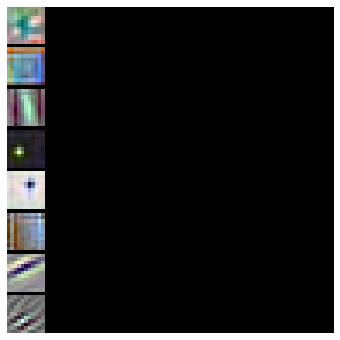

In [13]:
# first (next) parameter should be convolutional
conv_params = next(model.parameters()).data.cpu().numpy()
grid = visualize_grid(conv_params.transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(6, 6)
plt.show()